In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from matplotlib import colors
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sqlalchemy.exc import OperationalError
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from xhistogram.xarray import histogram
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
import cython
from dask.distributed import Client, LocalCluster

warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = LocalCluster()  
cluster

In [3]:
client = Client(cluster)

In [4]:
client

<Client: 'tcp://127.0.0.1:37167' processes=8 threads=48, memory=48.00 GiB>

In [5]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1834030    seseml interact alfonso8  R    1:44:06      1 keeling-j01


In [6]:
def metrics(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x) 
    corr = xr.corr(x, xpred).compute()**2.
    return rmse.compute().values, mae.compute().values, corr.values

def metrics_pd(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x) 
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def norm_gamma2(d, nw, dm, mu):
    return nw * (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4)) * (d / dm) ** mu * np.exp(-(mu + 4) * d / dm)

In [7]:
aircraft = 'Lear'
aircraft2 = 'Learjet'
aircraft1 = 'P3B'
aircraft3 = 'P3B'

In [8]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr.zarr"


In [9]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)

In [10]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

In [11]:
new_cols = ['sigma', 'sigmap', 'dm', 'log10_nw', 'mu', 'r', 'dfr', 'dbz_t_ka', 'dbz_t_ku', 'nt', 'lwc_cum', 'temp', 'vert_vel', 'altitude', "dm_true", 
            "dm_rt_dfr_nd", "dm_rt_dfr_gm_mu_3", 'log10nw_true_mu_dm', 'log10nw_true', 'log10nw_dm_nd', 'log10nw_dm_gm_mu_3', 'r_true_nw_mu_dm', 'r_dm_gm_mu_3', 
           'r_dm_nd', 'r_will', 'r_camp','r_gpm_operational', 'mu_williams', 'mu_camp','dm_williams', 'log10nw_will', 'dm_camp', 'log10nw_camp']

In [12]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [13]:
df = ds.to_dataframe()
df.shape

(8710, 33)

In [14]:
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']
df['dm_class'] = (df.dm >= 1.0).astype(int)
df.shape

(8710, 34)

In [15]:
df['logr'] = np.log10(df.r)
df['lognt'] = np.log10(df.nt)
df['loglwc'] = np.log10(df.lwc_cum)

cols = ['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]
scaler = StandardScaler()
df[cols]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

df['kmeans_6'] = kmeans.labels_

In [16]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})

In [17]:
from matplotlib.colors import ListedColormap

# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap6 = ListedColormap(sns.color_palette(flatui).as_hex())

colors6 = my_cmap6(np.linspace(0,1,n_c))

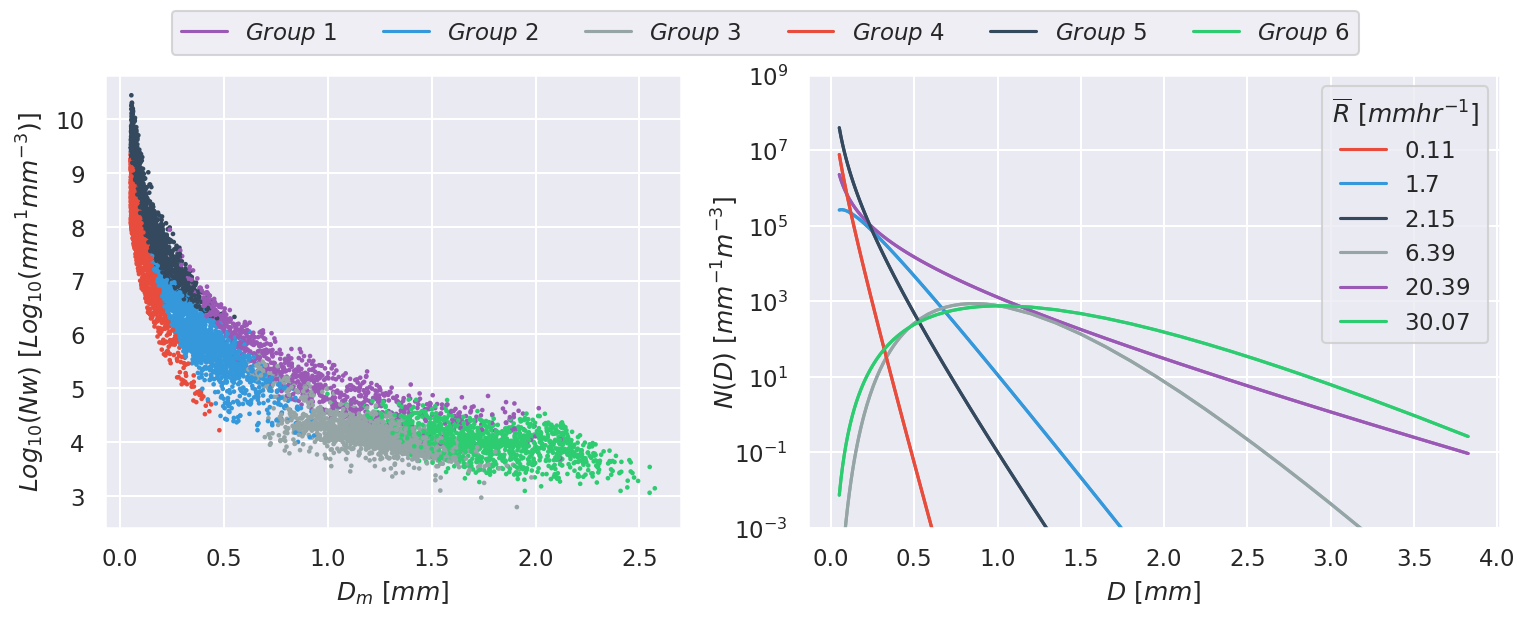

In [18]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
# fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds_lear.diameter/1000, gm, c=colors6[i], label=f"$Group \ {i + 1}$")
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    # ax1.plot(ds_lear.diameter/1000, gm, c=colors6[i], label=f"$Group \ {i + 1}$")
    ax1.plot(ds_lear.diameter/1000, gm, c=colors6[i], label=r"${}$".format(np.round(df_sub.r.mean(), 2)))
    
handles, labels = ax1.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) 
labels = list(labels[:6])
handles = list(handles[:6])
labels = [labels[0], labels[1], labels[2], labels[-1], labels[3], labels[4]]
handles = [handles[0], handles[1], handles[2], handles[-1], handles[3], handles[4]]
leg = ax1.legend(handles, labels)
leg.set_title("$\overline{R} \ [mmhr^{-1}]$") 
plt.savefig("../results/kmeans_w_r.jpeg", bbox_inches = "tight")

In [19]:
ds_merg = xr.concat([ds_lear, ds_p3b], dim='time')
ds_merg = ds_merg.where(ds_merg.lwc_cum > 0.01, drop=True)
ds_merg['kmeans'] = (['time'], df.kmeans_6.values) 
ds_merg['dfr'] = (['time'], (ds_merg['dbz_t_ku'] - ds_merg['dbz_t_ka']).values)

In [20]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [21]:
xbins = np.linspace(ds_merg.dm.min(), ds_merg.dm.max(), 50)
ybins = np.linspace(ds_merg.log10_nw.min(), ds_merg.log10_nw.max(), 50)
psd = histogram(ds_merg.dm, ds_merg.log10_nw, bins=[xbins, ybins])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


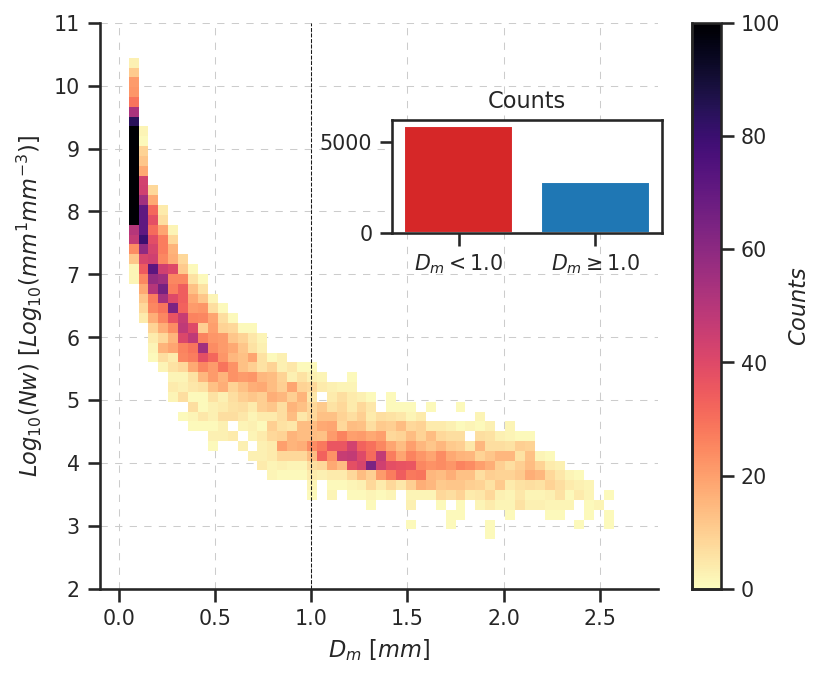

In [22]:
fig, ax = plt.subplots(figsize=(6,5))
im = psd.T.where(psd.T > 0, np.nan).plot(add_colorbar=False, ax=ax, cmap='magma_r', vmin=0, vmax=100)
fig.colorbar(im , ax=ax, label=r"$Counts$")
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
sns.despine()
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax.set_xlim(-0.1, 2.8)
ax.set_ylim(2, 11)
ax.vlines(x=1, ymin=2, ymax=11, lw=0.5, linestyle='--', color='k')

l, b, h, w = .45, .60, .15, .3
ax2 = fig.add_axes([l, b, w, h])
bar_colors = ['tab:red', 'tab:blue']
ax2.bar(['$D_m < 1.0$', "$D_m \geq 1.0$"], np.bincount(df['dm_class']), color=bar_colors)
ax2.set_title("Counts")
plt.savefig("../results/histogram.svg", bbox_inches='tight')

In [23]:
lower, greater = np.bincount(df['dm_class'])
total = greater + lower
print('Examples:\n    Total: {}\n    greater: {} ({:.2f}% of total)\n'.format(
    total, greater, 100 * greater / total))

Examples:
    Total: 8710
    greater: 2807 (32.23% of total)



Text(0, 0.5, 'Counts')

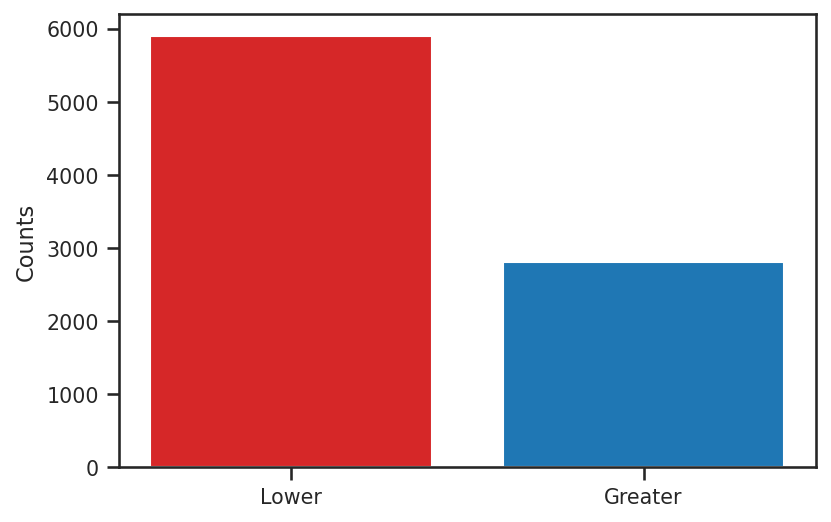

In [24]:
bar_colors = ['tab:red', 'tab:blue']
fig, ax = plt.subplots()
ax.bar(['Lower', "Greater"], np.bincount(df['dm_class']), color=bar_colors)
ax.set_ylabel("Counts")

## LEAR

In [25]:
# bins = np.arange(100, 5000, 200)
# ds_g = ds_lear.groupby(ds_lear.time.dt.day)
# k_lear = list(ds_g.groups.keys())
# fig, axs = plt.subplots(3, 4, figsize=(14, 8), sharex=True)
# norm = colors.Normalize(800, 5000)
# cmap = pl.cm.get_cmap("viridis")
# for idx, ax  in enumerate(axs.flatten()):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(10, 10000)
#     try:
#         ds_new = ds_g[k_lear[idx]].psd.groupby_bins(ds_g[k_lear[idx]].altitude, bins)
#         ks = sorted(list(ds_new.groups.keys()))
#         for idx2, i in enumerate(ks):
#             y = np.where(ds_new[i].mean('time') > 0, ds_new[i].mean('time'), np.nan) * 1e6
#             # if idx != 0:
#             #     y = y * 10**idx 
#             # # ax.step(ds_new[i].diameter, y, label=f'{i.mid}')
#             ax.plot(ds_new[i].diameter, y, c=cmap(norm(i.mid)))
#         ax.set_title(f"{pd.to_datetime(ds_g[k_lear[idx]].time.values[0]): %Y-%m-%d}", y=1.01)
#         ax.grid(which='both')
#     except IndexError as e:
#         print(e)
#         pass
#     # ax.set_yticklabels([])
#     ax.grid(which='both', color='grey', lw=0.5)


# plt.tight_layout()
# fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, label='$Height \  [m]$', pad=0.01, aspect=50)

In [26]:
# bins = np.arange(100, 5000, 200)
# for _, ds1 in ds_lear.groupby(ds_lear.time.dt.day):
#     try:
#         ds1 = ds1.where(ds1.lwc_cum > 0.01, drop=True)
#         fig, (ax, ax1, ax2, ax3) =  plt.subplots(1, 4, figsize=(13,4), sharey=True, dpi=150)
#         lwc = ds1.lwc_cum.groupby_bins(ds1.altitude, bins).mean().values
#         sd = ds1.sigma.groupby_bins(ds1.altitude, bins).mean().values
#         dm = ds1.dm.groupby_bins(ds1.altitude, bins).mean().values
#         nt = ds1.nt.groupby_bins(ds1.altitude, bins).mean().values
#         ax.plot(dm, bins[:-1], c='k')
#         ax.set_ylabel(r"$Height \ [m]$")
#         # ax.set_ylim(0, 2500)
#         ax.set_xlabel(r'$Dm \ [\mu m]$')
#         ax1.plot(sd, bins[:-1], c='k')
#         ax1.set_xlabel(r'$\sigma \ [\mu m]$')
#         ax2.plot(lwc, bins[:-1], c='k')
#         ax2.set_xlabel(r'$LWC \ [g m^{-1}]$')
#         ax3.plot(nt, bins[:-1], c='k')
#         ax3.set_xlabel(r'$N_{t} \ [cm^{-3}]$')
#         # ax3.set_xscale('log')
#         # ax3.set_xlim(0, 200)
#         fig.suptitle(f"${pd.to_datetime(ds1.time.values[0]): %Y-%m-%d}$")
#         fig.tight_layout()
#         plt.savefig(f'../results/properties_heigth_{pd.to_datetime(ds1.time.values[0]): %Y-%m-%d}')
#         plt.show()
#     except ValueError:
#         plt.close()
#         pass

## P3B

In [27]:
# ds_g = ds_p3b.groupby(ds_p3b.time.dt.day)
# k_p3 = list(ds_g.groups.keys())
# print(len(k_p3))
# fig, axs = plt.subplots(4, 5, figsize=(14, 8), sharex=True)
# norm = colors.Normalize(800, 5000)
# cmap = pl.cm.get_cmap("viridis")
# for idx, ax  in enumerate(axs.flatten()):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(10, 10000)
#     ax.minorticks_on
#     # ax.grid(which='major', color='grey', lw=0.5)
#     # ax.grid(which='minor', color='grey', lw=0.5)
#     ax.set_xticks([1e1,1e2, 1e3, 1e4])

#     try:
#         ds_new = ds_g[k_p3[idx]].psd.groupby_bins(ds_g[k_p3[idx]].altitude, bins)
#         ks = sorted(list(ds_new.groups.keys()))
#         for idx2, i in enumerate(ks):
#             y = np.where(ds_new[i].mean('time') > 0, ds_new[i].mean('time'), np.nan)
#             # if idx != 0:
#             #     y = y * 10**idx 
#             # # ax.step(ds_new[i].diameter, y, label=f'{i.mid}')
#             ax.plot(ds_new[i].diameter, y, c=cmap(norm(i.mid)))
#         ax.set_title(f"{pd.to_datetime(ds_g[k_p3[idx]].time.values[0]): %Y-%m-%d}", y=1.01)
#         ax.grid(True, which='both', color='grey', lw=0.5)
#     except IndexError as e:
#         print(e)
#         pass
   
    
#     # ax.grid( color='grey', lw=0.5)

#     # ax.set_yticklabels([])
    
# plt.tight_layout()
# fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, label='$Height \  [m]$', pad=0.01, aspect=50)

In [28]:
# bins = np.arange(100, 5000, 200)
# for _, ds1 in ds_p3b.groupby(ds_p3b.time.dt.day):
#     try:
#         ds1 = ds1.where(ds1.lwc_cum > 0.01, drop=True)
#         fig, (ax, ax1, ax2, ax3) =  plt.subplots(1, 4, figsize=(13,4), sharey=True, dpi=150)
#         lwc = ds1.lwc_cum.groupby_bins(ds1.altitude, bins).mean().values
#         sd = ds1.sigma.groupby_bins(ds1.altitude, bins).mean().values
#         dm = ds1.dm.groupby_bins(ds1.altitude, bins).mean().values
#         nt = ds1.nt.groupby_bins(ds1.altitude, bins).mean().values
#         ax.plot(dm, bins[:-1], c='k')
#         ax.set_ylabel(r"$Height \ [m]$")
#         # ax.set_ylim(0, 2500)
#         ax.set_xlabel(r'$Dm \ [\mu m]$')
#         ax1.plot(sd, bins[:-1], c='k')
#         ax1.set_xlabel(r'$\sigma \ [\mu m]$')
#         ax2.plot(lwc, bins[:-1], c='k')
#         ax2.set_xlabel(r'$LWC \ [g m^{-1}]$')
#         ax3.plot(nt, bins[:-1], c='k')
#         ax3.set_xlabel(r'$N_{t} \ [cm^{-3}]$')
#         # ax3.set_xscale('log')
#         # ax3.set_xlim(0, 200)
#         fig.suptitle(f"${pd.to_datetime(ds1.time.values[0]): %Y-%m-%d}$")
#         fig.tight_layout()
#         plt.savefig(f'../results/properties_heigth_{pd.to_datetime(ds1.time.values[0]): %Y-%m-%d}')
#         plt.show()
#     except ValueError:
#         plt.close()
#         pass

## All

In [29]:
ds_g = ds_merg.groupby(ds_merg.time.dt.dayofyear)
k_days = sorted(list(ds_g.groups.keys()))

In [30]:
# fig, axs = plt.subplots(5, 5, figsize=(14, 12), sharex=True)
# norm = colors.Normalize(800, 5000)
# cmap = pl.cm.get_cmap("viridis")

# for idx, ax  in enumerate(axs.flatten()):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(10, 5000)
#     ax.set_xticks([1e1,1e2, 1e3, 1e4])
#     ax.grid(which='both', color='grey', lw=0.1, axis='x')
#     ax.grid(which='both', color='grey', lw=0.1, axis='y')
#     try:
#         ds_new = ds_g[k_days[idx]].psd.groupby_bins(ds_g[k_days[idx]].altitude, bins)
#         ks = sorted(list(ds_new.groups.keys()))
#         for idx2, i in enumerate(ks):
#             y = np.where(ds_new[i].mean('time') > 0, ds_new[i].mean('time'), np.nan) * 1e6
#             # if idx != 0:
#             #     y = y * 10**idx 
#             # # ax.step(ds_new[i].diameter, y, label=f'{i.mid}')
#             ax.plot(ds_new[i].diameter, y, c=cmap(norm(i.mid)))
#         ax.set_title(f"{pd.to_datetime(ds_g[k_days[idx]].time.values[0]): %Y-%m-%d}", y=1.01)
#     except IndexError as e:
#         pass
#     # ax.set_yticklabels([])
# plt.tight_layout()
# fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, label='$Height \  [m]$', pad=0.01, aspect=50)

### to see all af them shifted uncomment an execute

In [31]:
# # ds_merg = xr.concat([ds_lear, ds_p3b], dim='time')
# ds_g = ds_merg.groupby(ds_merg.time.dt.dayofyear)
# k = sorted(list(ds_g.groups.keys()))
# fig, axs = plt.subplots(5, 5, figsize=(14, 16))
# norm = colors.Normalize(800, 5000)
# cmap = pl.cm.get_cmap("viridis")
# for idx, ax  in enumerate(axs.flatten()):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(1e1, 5000)
#     ax.grid(which='both', color='grey', lw=1., axis='x')
#     try:
#         ds_new = ds_g[k[idx]].psd.groupby_bins(ds_g[k[idx]].altitude, bins)
#         ks = sorted(list(ds_new.groups.keys()))
#         for idx2, i in enumerate(ks):
#             y = np.where(ds_new[i].mean('time') > 0, ds_new[i].mean('time'), np.nan)
#             if idx != 0:
#                 y = y * 10 ** idx2 
#             # # ax.step(ds_new[i].diameter, y, label=f'{i.mid}')
#             ax.plot(ds_new[i].diameter, y, c=cmap(norm(i.mid)))
#         ax.set_title(f"{pd.to_datetime(ds_g[k[idx]].time.values[0]): %Y-%m-%d}", y=0.98)
#     except IndexError as e:
#         pass
#     ax.set_yticklabels([])
    
# fig.tight_layout()
# fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, label='$Height \  [m]$', pad=0.01, aspect=50)

In [32]:
# mus = [-3, -1., 0., 1., 2., 3., 4., 10., 50., 110]

In [33]:
# ds_mus = ds_merg.groupby_bins(ds_merg.mu, mus)
# k_mus = sorted(list(ds_mus.groups.keys()))

## size distributions by mu

In [34]:
# fig, axis = plt.subplots(2,5, figsize=(13, 6), sharey=True, sharex=True)
# axs = axis.flatten()
# for idx, ax in enumerate(axs):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(2 * 1e-2, 5.)
#     ax.set_ylim(1e-1, 1e9)

#     try:
#         ## plot pds as function of height green scale
#         ds_new = ds_mus[k_mus[idx]].psd.groupby_bins(ds_mus[k_mus[idx]].altitude, bins)
#         ks = sorted(list(ds_new.groups.keys()))
#         for idx2, i in enumerate(ks):
#             y = np.where(ds_new[i].mean('time') > 0, ds_new[i].mean('time'), np.nan)* 1e6
#             ax.plot(ds_new[i].diameter / 1000, y, c=cmap(norm(i.mid)))
        
#         ## plot mean pds red line
#         ds_new = ds_mus[k_mus[idx]].psd.mean('time',skipna=True) * 1e6
#         y = np.where(ds_new > 0, ds_new, np.nan)
#         ax.plot(ds_new.diameter / 1000, y, label=f'{k_mus[idx]}', c='r', linewidth=3)
#         ax.set_title(f"{k_mus[idx]}", y=1.01)
#         ax.grid(which='both', color='grey', lw=0.8)
        
#         ## plot norm gamma 
#         nw = (10 ** (ds_mus[k_mus[idx]].log10_nw)).mean('time',skipna=True).values
#         mu = ds_mus[k_mus[idx]].mu_bf.mean('time',skipna=True).values
#         dm = ds_mus[k_mus[idx]].dm.mean('time',skipna=True).values
#         gm = norm_gamma(ds_lear.diameter/1000, nw=nw , mu=mu, dm=dm)
#         ax.plot(ds_lear.diameter / 1000, gm, color='m', lw=2)
#     except IndexError as e:
#         pass
#         ax.grid(which='both', color='grey', lw=0.8)

# fig.supylabel(r'$N(D) \ [mm^{-1} m^{-3}]$')
# fig.supxlabel(r'$Diameter \ [mm]$')
# fig.tight_layout()
# fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, label='$Height \  [m]$', pad=0.01, aspect=50)


In [35]:
# fig, (ax, ax1) = plt.subplots(1,2, figsize=(8, 4))
# for idx, _ in enumerate(k_mus):
#     nw = 10 ** (ds_mus[k_mus[idx]].log10_nw.mean('time',skipna=True)).values
#     mu = ds_mus[k_mus[idx]].mu.mean('time',skipna=True).values
#     dm = ds_mus[k_mus[idx]].dm.mean('time',skipna=True).values
#     gm = norm_gamma(ds_lear.diameter/1000, nw=nw , mu=mu, dm=dm)
#     ax.plot(ds_lear.diameter/1000, gm, label=k_mus[idx])
#     ax1.plot(ds_lear.diameter/1000, gm, label=k_mus[idx])
# ax.set_yscale('log')
# ax.set_ylim(1e-3, 1e7)
# ax.legend()
# ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e7)
# ax1.set_ylim(1e-3, 1e7)
# ax1.set_xscale('log')
# ax.legend(fontsize=8)

In [36]:
### next one is shifted distributions

In [37]:
# fig, axis = plt.subplots(2,5, figsize=(13, 6))
# axs = axis.flatten()
# for idx, ax in enumerate(axs):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(1e1, 5000)
#     ax.grid(which='both', color='grey', lw=1., axis='x')
#     try:
#         ds_new = ds_mus[k[idx]].psd.groupby_bins(ds_mus[k[idx]].altitude, bins)
#         ks = sorted(list(ds_new.groups.keys()))
#         for idx2, i in enumerate(ks):
#             y = np.where(ds_new[i].mean('time') > 0, ds_new[i].mean('time'), np.nan)
#             if idx != 0:
#                 y = y * 10 ** idx2 
#             # # ax.step(ds_new[i].diameter, y, label=f'{i.mid}')
#             ax.plot(ds_new[i].diameter, y, c=cmap(norm(i.mid)))
#         ax.set_title(f"{k[idx]}", y=0.98)
#     except IndexError as e:
#         pass
#     ax.set_yticklabels([])
    
# plt.tight_layout()
    
# fig.tight_layout()
# fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, label='$Height \  [m]$', pad=0.01, aspect=50)

In [38]:
# fig, ax = plt.subplots()
# ax.set_yscale('log')
# ax.set_ylim(1e-1, 1e7)
# ax.set_ylabel("N(D) [mm-1 m-3]")
# ax.set_xlabel("D [mm]")
# # ax.set_xscale('log')
# mus = [-3, -1., 0., 1., 2., 3., 4., 10., 50., 110]
# for i in mus:
#     gm = norm_gamma(ds_lear.diameter/1000, nw=1e4, mu=i, dm=1)
#     ax.plot(ds_lear.diameter/1000, gm, label=i)
# ax.legend()

In [39]:
# fig, ax = plt.subplots()
# for idx, mu in enumerate(mus):
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(1e1, 5000)
#     try:
#         ds_new = ds_mus[k_mus[idx]].psd.mean('time')
#         y = np.where(ds_new > 0, ds_new, np.nan) * 1e6
#         ax.plot(ds_new.diameter, y, label=f'{k_mus[idx]}')
#     except IndexError as e:
#         pass
    
# plt.tight_layout()
# ax.legend()

In [40]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [41]:
y_bins = 10 ** np.linspace(np.log10(ds_merg.psd.min()+0.000001), np.log10(ds_merg.psd.max() + 1e5), 40)
x_bins = 10 ** np.linspace(np.log10(1), np.log10(ds_merg.diameter.max()),30)

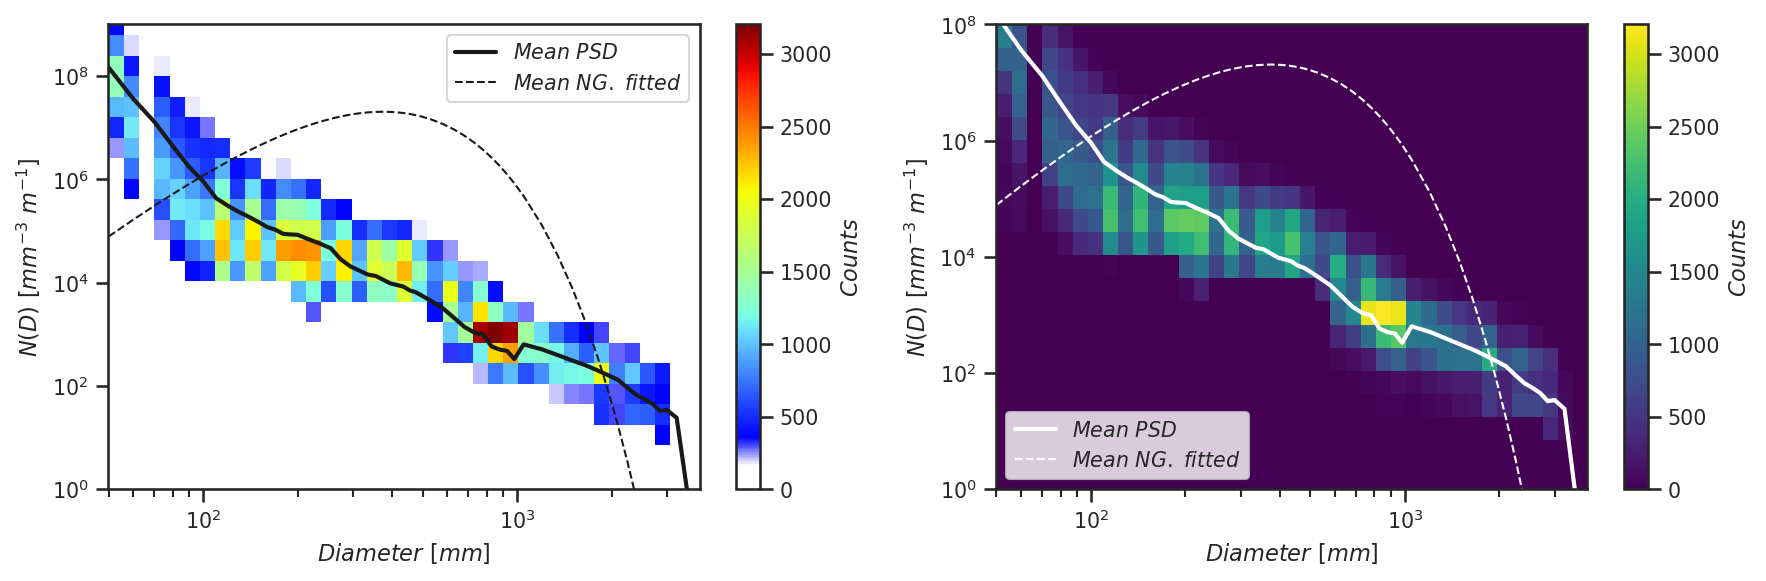

In [42]:
y_bins = 10 ** np.linspace(np.log10(ds_merg.psd.min() * 1e6 + 0.0001), np.log10(ds_merg.psd.max() * 1e6), 35)
x_bins = 10 ** np.linspace(np.log10(ds_merg.diameter.min()), np.log10(ds_merg.diameter.max()),40)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
## histogram
psd = histogram(ds_merg.diameter, ds_merg.psd * 1e6, bins=[x_bins, y_bins])
im = psd.T.plot(add_colorbar=False, cmap=my_cmap, ax=ax)
## mean psd
ax.plot(ds_merg.diameter, ds_merg.psd.mean('time', skipna=True) * 1e6, c='k', lw=2, label=r"$Mean \ PSD$")

## mean gamma shaped pds
nw = (10 ** (ds_merg.log10_nw)).mean('time',skipna=True).values
mu = ds_merg.mu.mean('time',skipna=True).values
dm = ds_merg.dm.mean('time',skipna=True).values
gm = norm_gamma(ds_lear.diameter/1000, nw=nw , mu=mu, dm=dm)
ax.plot(ds_lear.diameter, gm, color='k', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$N(D) \ [mm^{-3} \ m^{-1}]$')
ax.set_xlabel(r'$Diameter \ [mm]$')
ax.set_ylim(1e0, 1e9)
fig.colorbar(im, ax=ax, label="$Counts$")
ax.legend()

im1 = psd.T.plot(add_colorbar=False,)
## mean psd
ax1.plot(ds_merg.diameter, ds_merg.psd.mean('time', skipna=True) * 1e6, c='w', lw=2, label=r"$Mean \ PSD$")

## mean gamma shaped pds
nw = (10 ** (ds_merg.log10_nw)).mean('time',skipna=True).values
mu = ds_merg.mu.mean('time',skipna=True).values
dm = ds_merg.dm.mean('time',skipna=True).values
gm = norm_gamma(ds_lear.diameter/1000, nw=nw , mu=mu, dm=dm)
ax1.plot(ds_lear.diameter, gm, color='w', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")
ax1.legend()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'$N(D) \ [mm^{-3} \ m^{-1}]$')
ax1.set_xlabel(r'$Diameter \ [mm]$')
ax1.set_ylim(1e0, 1e8)
fig.colorbar(im1, ax=ax1, label="$Counts$")
fig.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


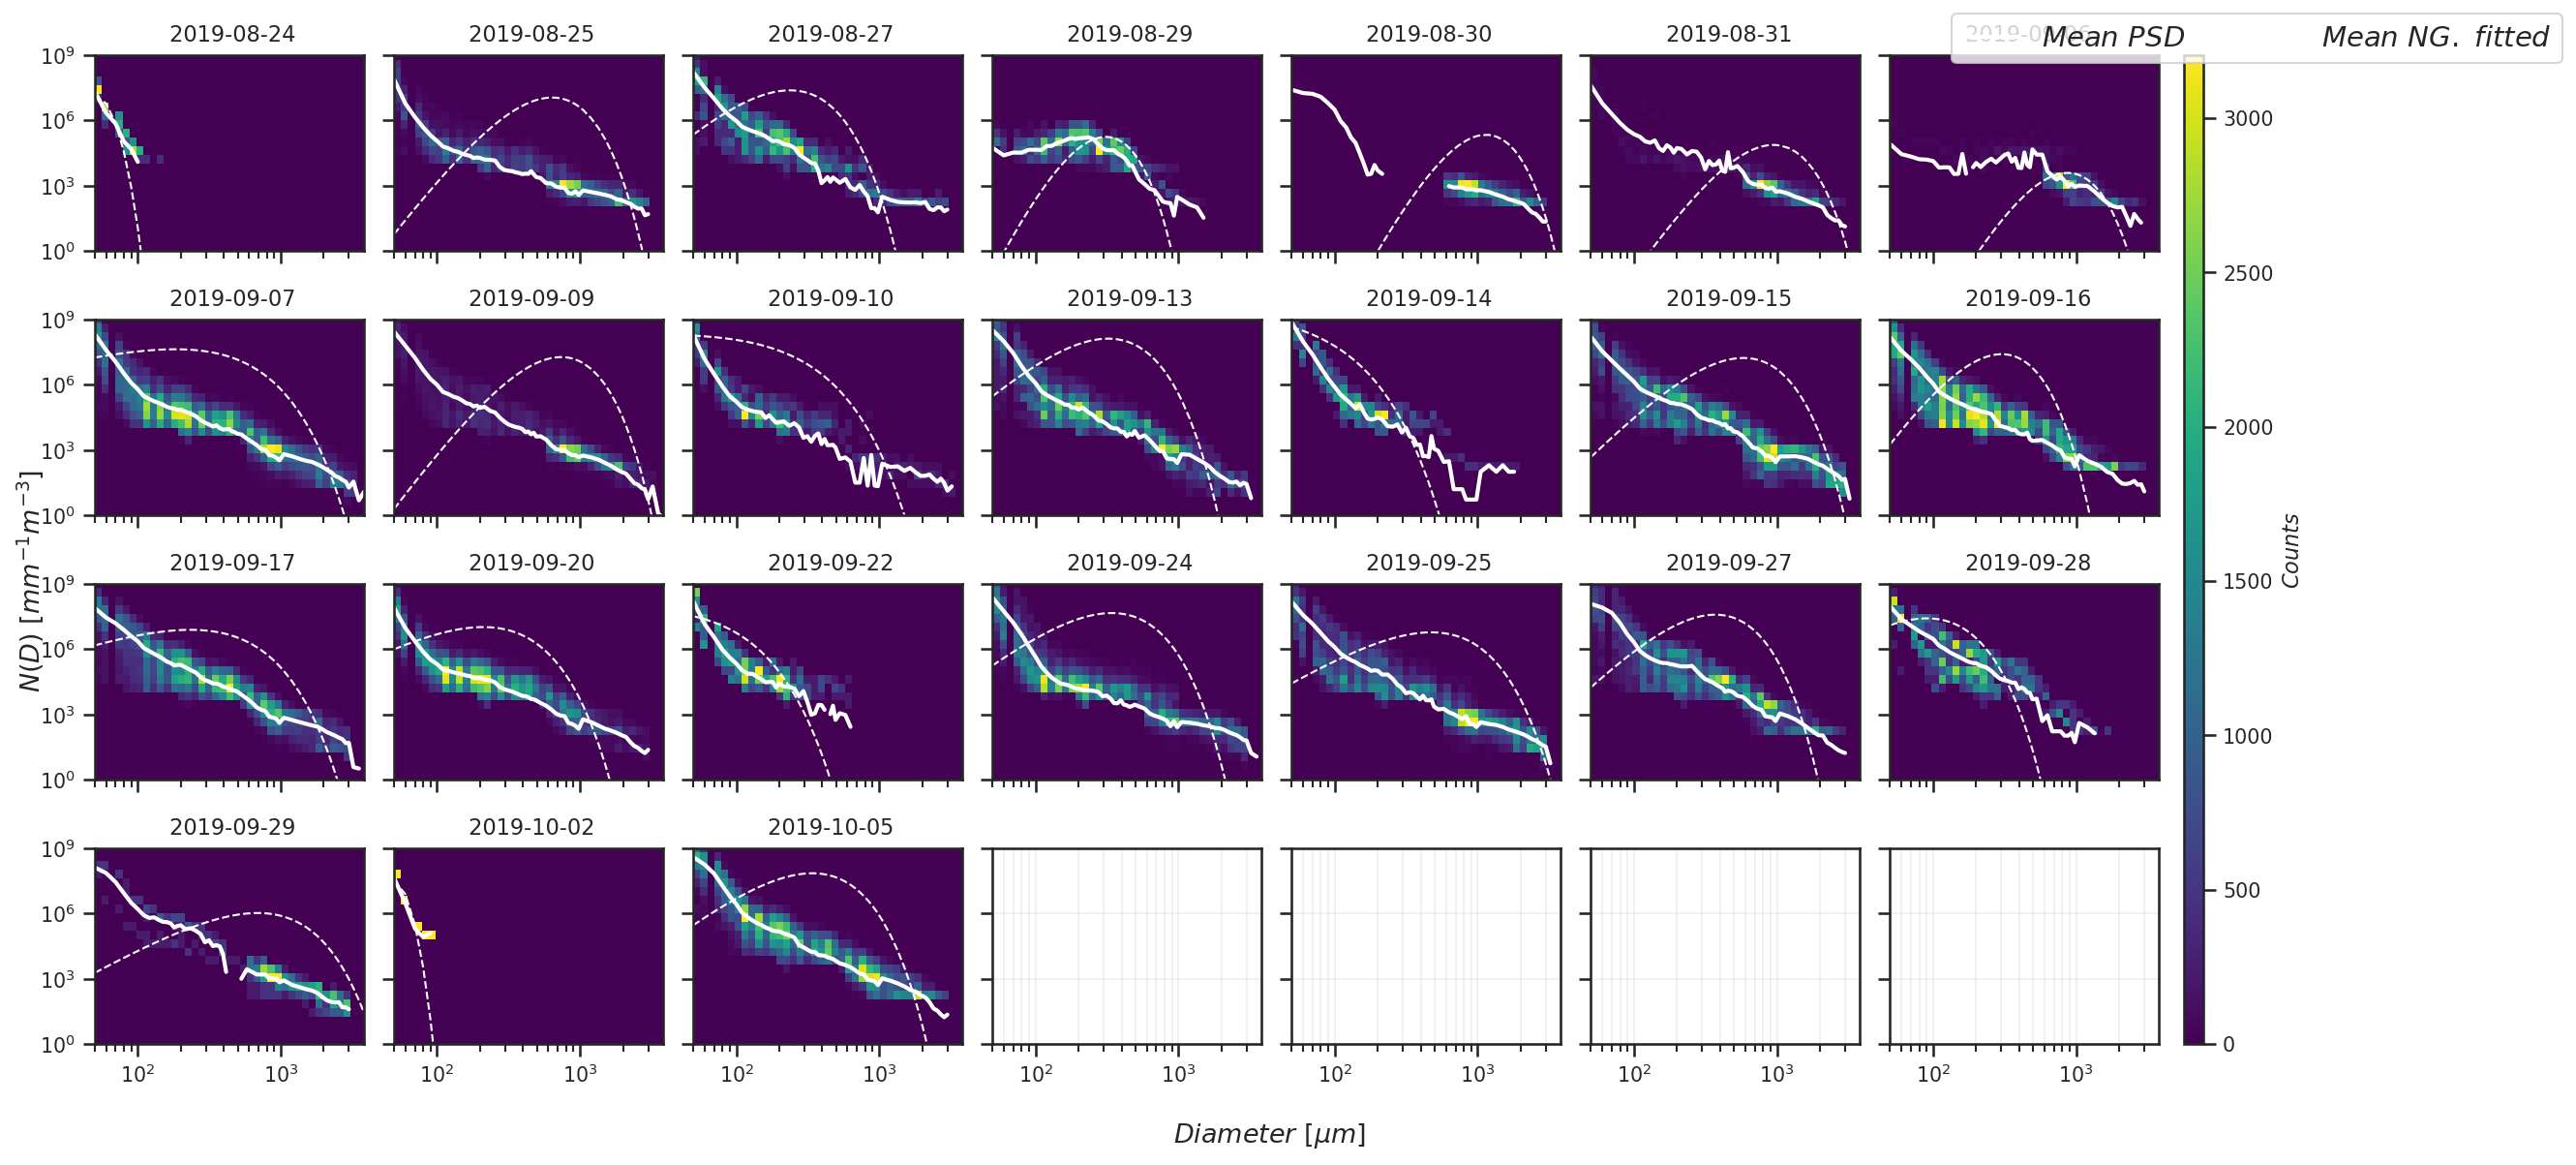

In [43]:
fig, axs = plt.subplots(4, 7, figsize=(18, 8), sharex=True, sharey=True)
norm = colors.Normalize(800, 5000)
cmap = pl.cm.get_cmap("viridis")

for idx, ax  in enumerate(axs.flatten()):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both', color='grey', lw=0.1, axis='x')
    ax.grid(which='both', color='grey', lw=0.1, axis='y')
    ax.set_ylim(1e0, 1e9)
    try:
        ds_new = ds_g[k_days[idx]]
        psd = histogram(ds_new.diameter, ds_new.psd * 1e6, bins=[x_bins, y_bins])
        psd.T.plot(add_colorbar=False, cmap='viridis', ax=ax)
        ## mean psd
        y = ds_new.psd.mean('time', skipna=True) * 1e6
        y = np.where(y > 0, y, np.nan)
        ax.plot(ds_new.diameter, y, c='white', lw=2, label=r"$Mean \ PSD$")
        
        nw = (10 ** (ds_new.log10_nw)).mean('time',skipna=True).values
        mu = ds_new.mu.mean('time',skipna=True).values
        dm = ds_new.dm.mean('time',skipna=True).values
        gm = norm_gamma(ds_new.diameter/1000, nw=nw , mu=mu, dm=dm)
        ax.plot(ds_new.diameter, gm, color='white', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")
        
        ax.set_title(f"{pd.to_datetime(ds_g[k_days[idx]].time.values[0]): %Y-%m-%d}", y=1.01)
        ax.set_ylabel('')
        ax.set_xlabel('')
    except IndexError as e:
        pass
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels[:1])]
fig.supylabel(r'$N(D) \ [mm^{-1} m^{-3}]$')
fig.supxlabel(r'$Diameter \ [\mu m]$')
fig.legend(lines, labels, ncol=2, fontsize=14)
plt.tight_layout()
fig.colorbar(im1, ax=axs, label='$Counts$', pad=0.01, aspect=50)


In [44]:
event = ds_lear.sel(time='2019-09-07 2:32:54', method='nearest')

1.34 1.49 56994.85


Text(0, 0.5, '$Log_{10}(Nw) \\ [Log_{10}(mm^{1}mm^{-3})]$')

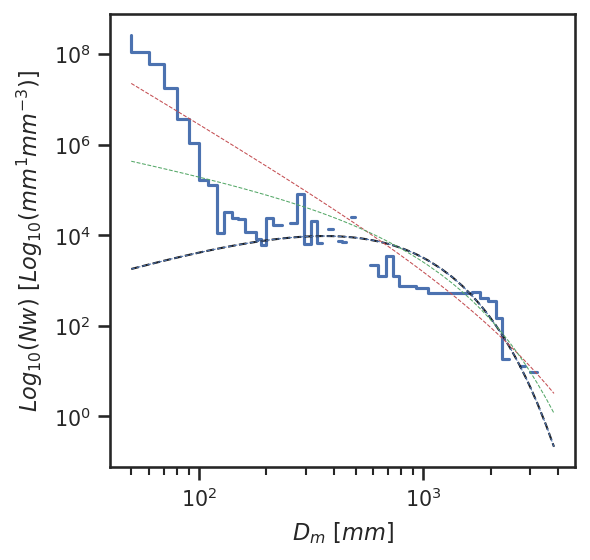

In [45]:
fig, ax = plt.subplots(figsize=(4,4))
ax.step(ds_lear.diameter, event.psd.where(event.psd > 0) * 1e6)
ax.set_yscale('log')
ax.set_xscale('log')

nw = 10 ** event.log10_nw.values
mu = event.new_mu.values
dm = event.dm.values
mu_3 = event.mu_bf.values
mu_bf = event.mu3.values
print(np.round(dm,2), np.round(mu, 2), np.round(nw, 2))
gm = norm_gamma(ds_new.diameter/1000, nw=nw, mu=mu, dm=dm)
gm2 = norm_gamma2(ds_new.diameter/1000, nw=nw, mu=mu, dm=dm)
gm3 = norm_gamma2(ds_new.diameter/1000, nw=nw, mu=mu_3, dm=dm)
gm4 = norm_gamma2(ds_new.diameter/1000, nw=nw, mu=mu_bf, dm=dm)
ax.plot(ds_new.diameter, gm, color='k', ls='--', lw=1, label=r'$Combined \  PDS$')
ax.plot(ds_new.diameter, gm2, color='b', ls='--', lw=0.5)
ax.plot(ds_new.diameter, gm3, color='r', ls='--', lw=0.5)
ax.plot(ds_new.diameter, gm4, color='g', ls='--', lw=0.5)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")

In [46]:
grps = np.arange(-0.5, 6.5, 1)
ds_km = ds_merg.groupby_bins(ds_merg.kmeans, grps)
km = sorted(list(ds_km.groups.keys()))
km

[Interval(-0.5, 0.5, closed='right'),
 Interval(0.5, 1.5, closed='right'),
 Interval(1.5, 2.5, closed='right'),
 Interval(2.5, 3.5, closed='right'),
 Interval(3.5, 4.5, closed='right'),
 Interval(4.5, 5.5, closed='right')]

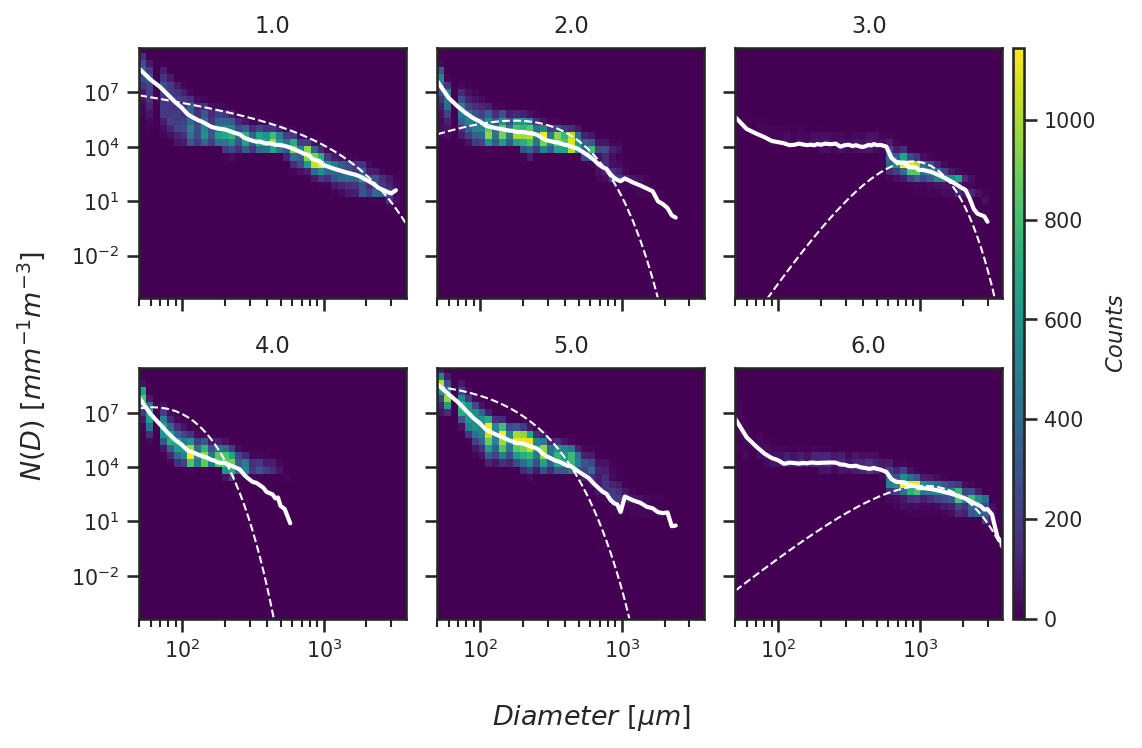

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
cmap = pl.cm.get_cmap("viridis")

y_bins = 10 ** np.linspace(np.log10(ds_merg.psd.min() * 1e6 + 0.0001), np.log10(ds_merg.psd.max() * 1e6), 35)
x_bins = 10 ** np.linspace(np.log10(ds_merg.diameter.min()), np.log10(ds_merg.diameter.max()),40)

for idx, ax  in enumerate(axs.flatten()):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both', color='grey', lw=0.1, axis='x')
    ax.grid(which='both', color='grey', lw=0.1, axis='y')
    ax.set_ylim(1e0, 1e9)
    # ax.set_xlim(1e-1, 1e3)
    try:
        ds_new = ds_km[km[idx]]
        psd = histogram(ds_new.diameter, ds_new.psd * 1e6, bins=[x_bins, y_bins])
        im1 = psd.T.plot(add_colorbar=False, cmap='viridis', ax=ax)
        ## mean psd
        y = ds_new.psd.mean('time', skipna=True) * 1e6
        y = np.where(y > 0, y, np.nan)
        ax.plot(ds_new.diameter , y, c='white', lw=2, label=r"$Mean \ PSD$")
        
        nw = (10 ** (ds_new.log10_nw)).mean('time',skipna=True).values
        mu = ds_new.mu.mean('time',skipna=True).values
        dm = ds_new.dm.mean('time',skipna=True).values
        gm = norm_gamma(ds_new.diameter / 1000, nw=nw , mu=mu, dm=dm)
        ax.plot(ds_new.diameter, gm, color='white', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")
        
        ax.set_title(f"{km[idx].mid + 1}", y=1.01)
        ax.set_ylabel('')
        ax.set_xlabel('')
    except IndexError as e:
        pass
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels[:1])]
fig.supylabel(r'$N(D) \ [mm^{-1} m^{-3}]$')
fig.supxlabel(r'$Diameter \ [\mu m]$')
# fig.legend(lines, labels, ncol=2, fontsize=14)
plt.tight_layout()
fig.colorbar(im1, ax=axs, label='$Counts$', pad=0.01, aspect=50)

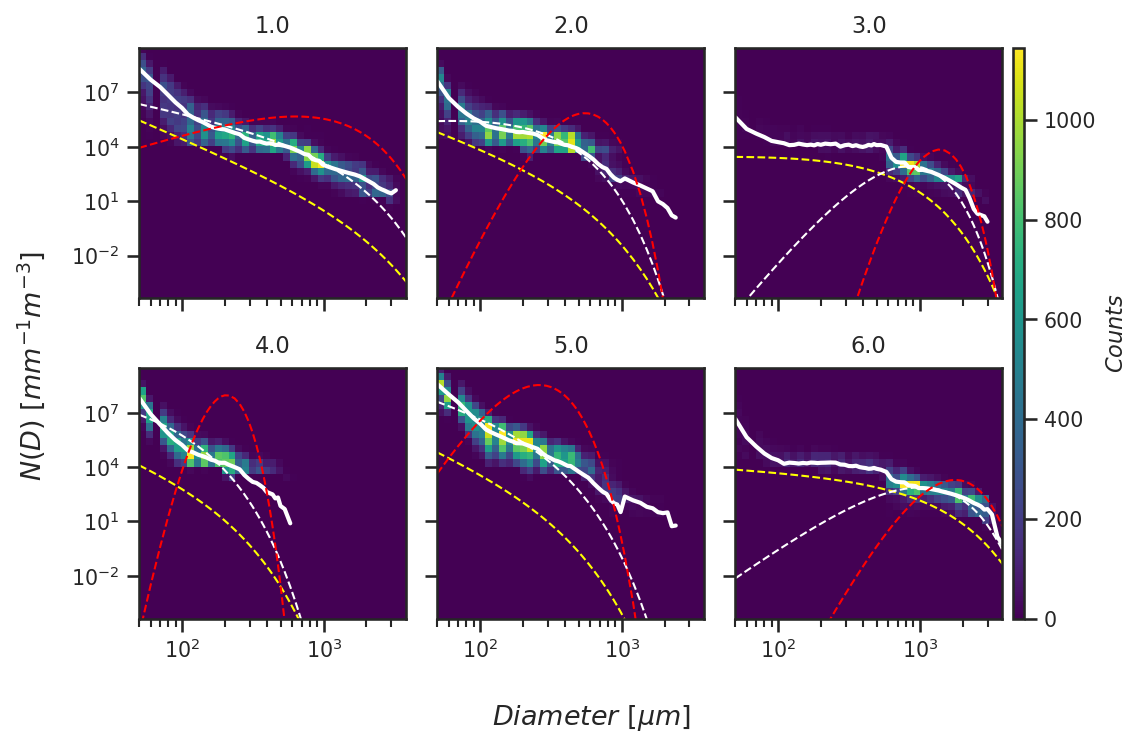

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
cmap = pl.cm.get_cmap("viridis")

y_bins = 10 ** np.linspace(np.log10(ds_merg.psd.min() * 1e6 + 0.0001), np.log10(ds_merg.psd.max() * 1e6), 35)
x_bins = 10 ** np.linspace(np.log10(ds_merg.diameter.min()), np.log10(ds_merg.diameter.max()),40)

for idx, ax  in enumerate(axs.flatten()):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both', color='grey', lw=0.1, axis='x')
    ax.grid(which='both', color='grey', lw=0.1, axis='y')
    ax.set_ylim(1e0, 1e9)
    # ax.set_xlim(1e-1, 1e3)
    try:
        ds_new = ds_km[km[idx]]
        psd = histogram(ds_new.diameter, ds_new.psd * 1e6, bins=[x_bins, y_bins])
        im1 = psd.T.plot(add_colorbar=False, cmap='viridis', ax=ax)
        ## mean psd
        y = ds_new.psd.mean('time', skipna=True) * 1e6
        y = np.where(y > 0, y, np.nan)
        ax.plot(ds_new.diameter , y, c='white', lw=2, label=r"$Mean \ PSD$")
        mus = ds_new.mu.load().quantile([0.05, 0.5, 0.95])
        nws = (10 ** ds_new.log10_nw).load().quantile([0.05, 0.5, 0.95])
        dms = ds_new.dm.load().quantile([0.05, 0.5, 0.95])
        # nw = (10 ** (ds_new.log10_nw)).mean('time',skipna=True).values
        # mu = ds_new.mu.mean('time',skipna=True).values
        # dm = ds_new.dm.mean('time',skipna=True).values
        gm = [norm_gamma(ds_new.diameter / 1000, nw=nws[i], mu=mus[i], dm=dms[i]) for i in range(len(mus))]
        ax.plot(ds_new.diameter, gm[0], color='yellow', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")
        ax.plot(ds_new.diameter, gm[1], color='white', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")
        ax.plot(ds_new.diameter, gm[2], color='red', ls='--', lw=1, label=r"$Mean \  NG. \  fitted$")
        
        ax.set_title(f"{km[idx].mid + 1}", y=1.01)
        ax.set_ylabel('')
        ax.set_xlabel('')
    except IndexError as e:
        pass
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels[:1])]
fig.supylabel(r'$N(D) \ [mm^{-1} m^{-3}]$')
fig.supxlabel(r'$Diameter \ [\mu m]$')
# fig.legend(lines, labels, ncol=2, fontsize=14)
plt.tight_layout()
fig.colorbar(im1, ax=axs, label='$Counts$', pad=0.01, aspect=50)